### Group Variation Metrics:
- Standard deviation (Normalized by total interval)
- Topic deviation
- Peak count
- Hurst exponent

### Distance Metrics over group topic distribution across intervals:
- KL Divergance : Distance between topic distribution over 2 year interval
- Modified Jaccard Index : Distance between top topic ranks over 2 year interval

In [1]:
from distfit import distfit
from kneed import KneeLocator
from scipy.signal import peak_widths
from pyfiles.mod_topic_influence_base import * 

In [2]:
topic_model = "./topic_models/topic_model_mathscinet_25_with_all_and_thesis_title.gensim"
topic_dict  = "./topic_models/dictionary_mathscinet_25_with_all_and_thesis_title.gensim"
corpus      = "./topic_models/corpus_mathscinet_25_with_all_and_thesis_title.pkl"

In [3]:
Min_publ   = 5 #(greater than )
Group_size = 5 #(greater than equal to)

In [4]:
start_time = time.time()
print("Running topic influence base")
filtered_groups, filtered_grp_member_cy, mgpid2publ_count, group_publication_titles, mgp_nodes, mgp_edges= group_info(Group_size) 
# with publication constraint for advisor and advisee
#     filtered_groups, filtered_grp_member_cy, mgpid2publ_count, group_publication_titles, mgp_nodes, mgp_edges=
#     group_info_without_constraint(5)
print(f"Total filtered groups: {len(filtered_groups)}")
lda_model, id2word = load_topic_model(topic_model, topic_dict, corpus)
lda_model.minimum_probability = 0.0
num_topics= lda_model.num_topics
group_head_id = [k for k,v in group_publication_titles.items() if len(v) > Min_publ]
topic_distribution_year = [(topic_distributions_over_interval((k,v), lda_model, id2word,prepare_text_for_lda)) 
                           for k,v in group_publication_titles.items() if len(v) > Min_publ]
interval_start_year = [i[0] for i in topic_distribution_year]
topic_distribution  = [i[1] for i in topic_distribution_year]
aggregated_distribution_topic_rank = [aggregate_dist_over_interval(dist=dist, i=i, rank=True, no_of_topics= num_topics) for i, dist in enumerate(topic_distribution)]
aggregated_distribution = [elem[0] for elem in aggregated_distribution_topic_rank]
topic_with_value        = [elem[1] for elem in aggregated_distribution_topic_rank]
topic_rank              = [[[value[0] for value in interval] for interval in researcher] 
                          for researcher in topic_with_value] #changed
metric_distance_kl  = [get_distance_over_interval(dist, i, kl_divergance) 
                      for i, dist in enumerate(aggregated_distribution)]
norm_distance_kl    = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                       for metrics in metric_distance_kl]

metric_distance_tau = [get_distance_over_interval(rank, i, modified_jaccard_index) 
                       for i, rank in enumerate(topic_rank)]
norm_distance_tau   = [list(np.array(metrics)/sum(metrics)) if sum(metrics) > 0.0 else metrics 
                       for metrics in metric_distance_tau]
assert len(interval_start_year) == len(aggregated_distribution) == len(metric_distance_kl) == len(metric_distance_tau) == len(group_head_id) == len(norm_distance_kl)==len(norm_distance_tau)
print(f"Number of groups (Publication count > {Min_publ}): {len(group_head_id)}")
print(f"Time taken (in minutes)= {(time.time() - start_time)/60}")

Running topic influence base
publication count: 2972504
Publication group by (author_id, year) count: 1390579
Total filtered groups: 17893
Number of groups (Publication count > 5): 15433
Time taken (in minutes)= 18.731378197669983


In [5]:
#filtered_grp_member = [(k,)+v for k,v in filtered_groups.items()]

In [6]:
#index_dict = dict([(kv[0], i) for i,kv in enumerate(filtered_groups.items())])

In [7]:
#interval_start_year[5997]

In [8]:
#index_dict[30480]

In [9]:
#filtered_groups[30480]

In [10]:
#filtered_grp_member_cy[6370]

In [11]:
#group_publication_titles[54114]

In [12]:
#len(topic_distribution[11264][1])

In [13]:
#aggregated_distribution_topic_rank[11264]

In [14]:
#did(norm_distance_kl[11264])

In [15]:
%store group_publication_titles
%store topic_with_value
%store topic_rank
%store norm_distance_kl
%store norm_distance_tau
%store mgp_nodes
%store group_head_id
%store filtered_groups
%store filtered_groups
%store aggregated_distribution

Stored 'group_publication_titles' (dict)
Stored 'topic_with_value' (list)
Stored 'topic_rank' (list)
Stored 'norm_distance_kl' (list)
Stored 'norm_distance_tau' (list)
Stored 'mgp_nodes' (DataFrame)
Stored 'group_head_id' (list)
Stored 'filtered_groups' (dict)
Stored 'filtered_groups' (dict)
Stored 'aggregated_distribution' (list)


In [16]:
%store lda_model
%store id2word
%store prepare_text_for_lda

Stored 'lda_model' (LdaMulticore)
Stored 'id2word' (Dictionary)
Stored 'prepare_text_for_lda' (function)


In [17]:
# def group_plot_metric(mgp_ids, year, metric_dist, researcher_id, name=""):
#     indexs =  [i for i, idd in enumerate(researcher_id) if idd in mgp_ids]
#     if len(indexs) > 0:
#         metric_dist = [[np.round(float(i), 2) for i in nested] for nested in metric_dist]
#         plt.figure(figsize=(8, 6), dpi=80)
#         for index in indexs:
            
#             if len(year[index][1:]) > 0:
#                 print(year[index])
#                 plt.plot(year[index][1:], metric_dist[index], label=f"MGP ID : {researcher_id[index]}",                             marker='o', markersize=5)
#             else:
#                 plt.plot(year[index], metric_dist[index], label=f"MGP ID : {researcher_id[index]}", marker='o',                     markersize=5)
#         plt.ylabel("Topic Distance Over Interval")#
#         plt.xlabel("Publication Year")
#         plt.legend()
#         plt.savefig(f"{fig_folder}/{name}.pdf")
#         plt.show()
#     else:
#         print(f"Advisor (Group leader : {mgp_id}) not present in the filtered dataset")
#     return

In [18]:
# def find_from_filtered_top_lowest(metrics, group_head_id, zero_include = True, top=10, index_between=None):
#     res_metric        = [(head, metric) for head, metric in zip(group_head_id, metrics)]
#     sorted_res_metric = sorted(res_metric, key= lambda x: x[1], reverse=True)
#     if index_between:
#         sorted_res_metric = [t for i, t in enumerate(sorted_res_metric) if i >= index_between[0] 
#                              and i<index_between[1]]
#     #print(sorted_res_metric[0:5])
#     if zero_include: 
#         res = [i[0] for i in sorted_res_metric]
#     else:
#         res = [i[0] for i in sorted_res_metric if i[1] > 0]
#     persistent_res      = res[-top:] #if i[1] > 0
#     anti_persistent_res = res[:top]  #if i[1] > 0
#     return persistent_res[::-1], anti_persistent_res

In [9]:
cv   = lambda x: np.std(x)/np.mean(x) #co-efficient of variation

In [10]:
did1 = lambda x: abs(list(np.diff(x, len(x)-1))[0]) #difference in difference

In [11]:
did2 = lambda x: np.std(np.diff(x,2))*np.std(x)

In [12]:
did3 = lambda x: np.std(np.diff(x,2))*len(find_peaks(x)[0])

In [13]:
did4 = lambda x: (np.std(np.diff(x,1))*np.std(x))

In [14]:
did  = lambda x: (np.std([abs(d) for d in np.diff(x,1)])*np.std(x))

In [15]:
peak_width = lambda x: np.sum([np.diff(p) for p in peak_widths(x, find_peaks(x)[0])])# rel_height=0.5

In [16]:
len(find_peaks(norm_distance_tau[1])[0])

5

In [17]:
#norm_distance_tau[0]

In [18]:
#did(norm_distance_tau[0])

In [19]:
#peak_width(norm_distance_tau[0])

In [20]:
#np.diff(norm_distance_tau[0], 14)

In [21]:
# # standard deviation
# metric_std_tau   = [np.std(interval) for interval in norm_distance_tau]
# metric_peaks_tau = [len(find_peaks(interval)[0]) for interval in norm_distance_tau]

# # with Kullback–Leibler divergence (KL-Divergance)
# metric_std_kl   = [np.std(interval) for interval in norm_distance_kl]
# metric_peaks_kl = [len(find_peaks(interval)[0]) for interval in norm_distance_kl]

# persistent_res_kl, anti_persistent_res_kl = find_from_filtered_top_lowest(metric_std_kl, group_head_id, zero_include=False, top=10, index_between=(0,len(group_head_id)))

# persistent_res_tau, anti_persistent_res_tau = find_from_filtered_top_lowest(metric_std_tau, group_head_id, zero_include=False, top=10, index_between=(0,len(group_head_id)))

# persistent_detail     = get_names(mgp_nodes, persistent_res_kl)

# not_persistent_detail = get_names(mgp_nodes, anti_persistent_res_kl)

In [22]:
metric_std_tau   = [did(interval) for interval in norm_distance_tau]
metric_peaks_tau = [len(find_peaks(interval)[0]) for interval in norm_distance_tau]

# with Kullback–Leibler divergence (KL-Divergance)
metric_std_kl   = [did(interval) for interval in norm_distance_kl]
metric_peaks_kl = [len(find_peaks(interval)[0]) for interval in norm_distance_kl]

persistent_res_kl, anti_persistent_res_kl, res_kl= find_from_filtered_top_lowest(metric_std_kl, group_head_id, zero_include=False, top=10, index_between=(0,len(group_head_id)))

persistent_res_tau, anti_persistent_res_tau, res_tau= find_from_filtered_top_lowest(metric_std_tau, group_head_id, zero_include=False, top=10, index_between=(0,len(group_head_id)))

persistent_detail     = get_names(mgp_nodes, persistent_res_kl)

not_persistent_detail = get_names(mgp_nodes, anti_persistent_res_kl)

In [23]:
res_kl[:10]

[100552, 71060, 175362, 192953, 86658, 18526, 16006, 135530, 46043, 3867]

In [24]:
score_dict = dict([(head, (metric,i)) for i,(head, metric) in enumerate(zip(group_head_id, metric_std_kl))])

In [25]:
norm_distance_kl[6783]

[-2.220446049250313e-16,
 0.0,
 2.2204460492503128e-16,
 -2.220446049250313e-16,
 2.2204460492503128e-16,
 0.0]

In [26]:
score_dict[11769]

(0.00010224179075400126, 855)

In [27]:
%store persistent_res_kl
%store anti_persistent_res_kl
%store persistent_res_tau
%store anti_persistent_res_tau

Stored 'persistent_res_kl' (list)
Stored 'anti_persistent_res_kl' (list)
Stored 'persistent_res_tau' (list)
Stored 'anti_persistent_res_tau' (list)


In [28]:
persistent_detail

[(73922,
  'Nikolay Grigorievich Chebotarev',
  'Kiev State University',
  'Ukraine'),
 (147523, 'Iraj  Mahdavi', nan, nan),
 (30598, 'Harry  Kesten', 'Cornell University', 'UnitedStates'),
 (14737, 'Donald A. S. Fraser', 'Princeton University', 'UnitedStates'),
 (7298, 'David  Hilbert', 'Universität Königsberg', 'Germany'),
 (41774, 'John Bryce McLeod', 'University of Oxford', 'UnitedKingdom'),
 (8008,
  'Johannes Henricus Bernardus Kemperman',
  'Universiteit van Amsterdam',
  'Netherlands'),
 (13113,
  'Richard James Duffin',
  'University of Illinois at Urbana-Champaign',
  'UnitedStates'),
 (14011, 'Stephen Arthur Cook', 'Harvard University', 'UnitedStates'),
 (7373,
  'Hermann Claus Hugo Weyl',
  'Georg-August-Universität Göttingen',
  'Germany')]

In [29]:
not_persistent_detail

[(100552, 'Ghasem  Barid Loghmani', 'University of Kerman', 'Iran'),
 (71060, 'Li-Shiuan  Peh', 'Stanford University', 'UnitedStates'),
 (175362, 'Gilles  Celeux', nan, nan),
 (192953, 'Huijiang  Zhao', nan, nan),
 (86658, 'Nur Ali Touba', 'Stanford University', 'UnitedStates'),
 (18526,
  'Harrie Stewart Wilson Massey',
  'University of Cambridge',
  'UnitedKingdom'),
 (16006, 'Frantisek  Franek', 'University of Toronto', 'Canada'),
 (135530,
  'David Bradley Spencer',
  'University of Colorado at Boulder',
  'UnitedStates'),
 (46043,
  'Ulrich  Berger',
  'Ludwig-Maximilians-Universität München',
  'Germany'),
 (3867,
  'Linda Joy Svoboda Allen',
  'University of Tennessee - Knoxville',
  'UnitedStates')]

In [30]:
metric_std_kl = [0 if pd.isna(m) else m for m in metric_std_kl]

In [31]:
y = sorted(metric_std_kl, reverse=True)

In [32]:
#y[-100:]

In [33]:
x  = range(0, len(y))
kn = KneeLocator(x, y, curve='convex', direction='decreasing', interp_method="polynomial")
print(kn.elbow)

1733


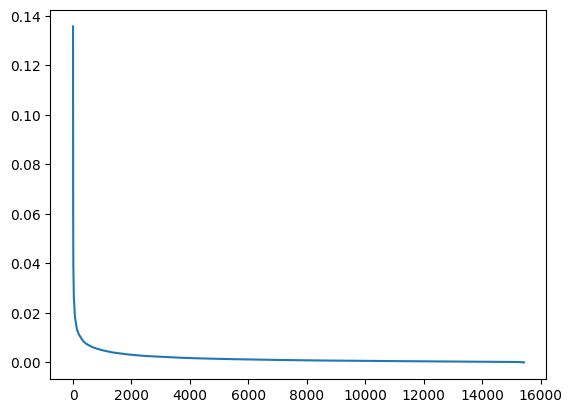

In [34]:
ax = plt.axes()
ax.plot(y)
#ax.axvline(x=kn.elbow, ymin=0, ymax=y[kn.elbow]+0.09)
#ax.axvline(x=kn.elbow+1500, ymin=0, ymax=y[kn.elbow+1500]+0.08)
#ax.axvline(x=kn.elbow-1500, ymin=0, ymax=y[kn.elbow-1500]+0.15)
plt.savefig(f"{fig_folder}/elbow_identification.pdf")
plt.show()

In [35]:
#After elbow point indentification,extraction of persistent and anti-persistent researchers
inter_val=1000

#index_between = (kn.elbow-inter_val, kn.elbow+inter_val)
index_between = (0, kn.elbow)


persistent_res_kl1, anti_persistent_res_kl1, res_kl1 = find_from_filtered_top_lowest(metric_std_kl, group_head_id, zero_include  =True, top=10, index_between=index_between)

persistent_res_tau1, anti_persistent_res_tau1, res_tau1 = find_from_filtered_top_lowest(metric_std_tau, group_head_id, zero_include =True, top=10, index_between=index_between)

persistent_detail1     = get_names(mgp_nodes, persistent_res_kl1)


not_persistent_detail1 = get_names(mgp_nodes, anti_persistent_res_kl1)

In [36]:
%store persistent_res_kl1
%store anti_persistent_res_kl1
%store persistent_res_tau1
%store anti_persistent_res_tau1

Stored 'persistent_res_kl1' (list)
Stored 'anti_persistent_res_kl1' (list)
Stored 'persistent_res_tau1' (list)
Stored 'anti_persistent_res_tau1' (list)


In [37]:
persistent_res_kl1, anti_persistent_res_kl1

([93095, 209830, 80103, 69482, 48088, 63368, 88194, 54318, 62276, 194275],
 [100552, 71060, 175362, 192953, 86658, 18526, 16006, 135530, 46043, 3867])

In [38]:
persistent_res_tau1, anti_persistent_res_tau1

([81044, 105845, 73323, 76331, 13509, 212658, 107177, 161079, 41975, 15316],
 [18526, 86658, 135530, 193157, 192953, 47257, 57890, 23206, 175301, 36441])

In [39]:
persistent_detail1

[(93095,
  'Kim-Kwang Raymond  Choo',
  'Queensland University of Technology',
  'Australia'),
 (209830,
  'Guido  Lorenzoni',
  'Massachusetts Institute of Technology',
  'UnitedStates'),
 (80103, 'Saeid  Abbasbandy', 'Teacher Training University\t Tehran', 'Iran'),
 (69482, 'Michael David Smith', 'Stanford University', 'UnitedStates'),
 (48088, 'Jianwen  Cai', 'University of Washington', 'UnitedStates'),
 (63368,
  'Rolf  Drechsler',
  'Johann Wolfgang Goethe-Universität Frankfurt am Main',
  'Germany'),
 (88194, 'Thomas Simon Lumley', 'University of Washington', 'UnitedStates'),
 (54318, 'Luc J. van Gool', 'Katholieke Universiteit Leuven', 'Belgium'),
 (62276,
  'Jared Wade Tanner',
  'University of California\t Los Angeles',
  'UnitedStates'),
 (194275, 'Michael Anthony Stroscio', 'Yale University', 'UnitedStates')]

In [40]:
not_persistent_detail1

[(100552, 'Ghasem  Barid Loghmani', 'University of Kerman', 'Iran'),
 (71060, 'Li-Shiuan  Peh', 'Stanford University', 'UnitedStates'),
 (175362, 'Gilles  Celeux', nan, nan),
 (192953, 'Huijiang  Zhao', nan, nan),
 (86658, 'Nur Ali Touba', 'Stanford University', 'UnitedStates'),
 (18526,
  'Harrie Stewart Wilson Massey',
  'University of Cambridge',
  'UnitedKingdom'),
 (16006, 'Frantisek  Franek', 'University of Toronto', 'Canada'),
 (135530,
  'David Bradley Spencer',
  'University of Colorado at Boulder',
  'UnitedStates'),
 (46043,
  'Ulrich  Berger',
  'Ludwig-Maximilians-Universität München',
  'Germany'),
 (3867,
  'Linda Joy Svoboda Allen',
  'University of Tennessee - Knoxville',
  'UnitedStates')]

In [41]:
# def group_plot_metric(mgp_ids, year, metric_dist, researcher_id, name="", flag="", ylim=None):
#     if flag=="researcher":
#         txt= "MGP ID: "
#     else:
#         txt = ""
#     indexs =  [i for i, idd in enumerate(researcher_id) if idd in mgp_ids]
#     if len(indexs) > 0:
#         metric_dist = [[np.round(float(i), 2) for i in nested] for nested in metric_dist]
#         plt.figure(figsize=(8, 6), dpi=80)
#         for index in indexs:
            
#             if len(year[index][1:]) > 0:
#                 #print(year[index])
#                 plt.plot(year[index][1:], metric_dist[index], label=f"{txt}{researcher_id[index]}",                             marker='o', markersize=5)
#             else:
#                 plt.plot(year[index], metric_dist[index], label=f"{txt}{researcher_id[index]}", marker='o',                     markersize=5)
#         plt.ylabel("Topic Distance Over Interval")#
#         plt.xlabel("Publication Year")
#         plt.ylim(ylim)
#         plt.legend()
#         plt.savefig(f"{fig_folder}/{name}.pdf")
#         plt.show()
#     else:
#         print(f"Advisor (Group leader : {mgp_id}) not present in the filtered dataset")
#     return

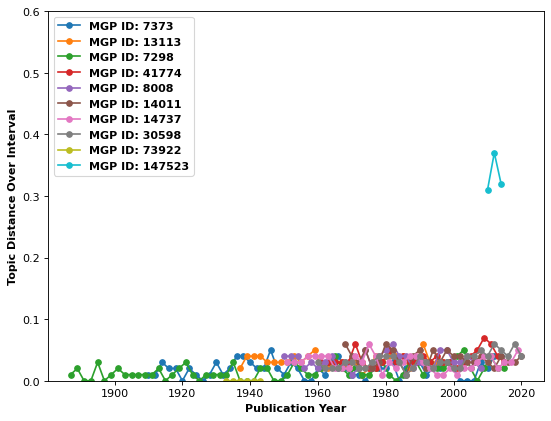

In [42]:
group_plot_metric(persistent_res_kl[:10], interval_start_year, norm_distance_kl, group_head_id, name="persistent_kl",flag="researcher",ylim=(0,0.6))

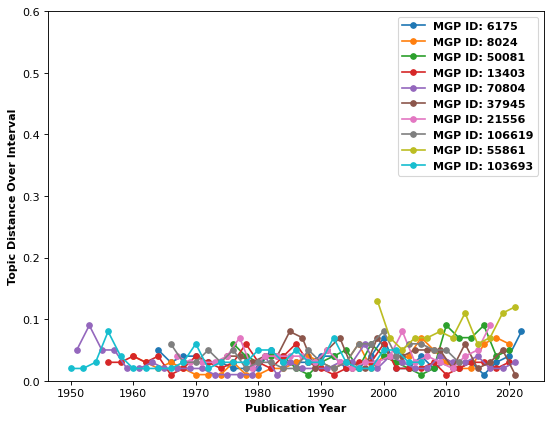

In [43]:
group_plot_metric(persistent_res_tau[:10], interval_start_year, norm_distance_kl, group_head_id, name="persistent_jaccard",flag="researcher",ylim=(0,0.6))

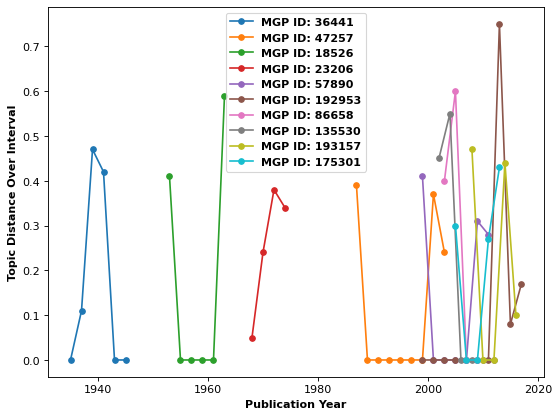

In [44]:
group_plot_metric(anti_persistent_res_tau[:10], interval_start_year, norm_distance_kl, group_head_id, name="not_persistent_jaccard",flag="researcher")

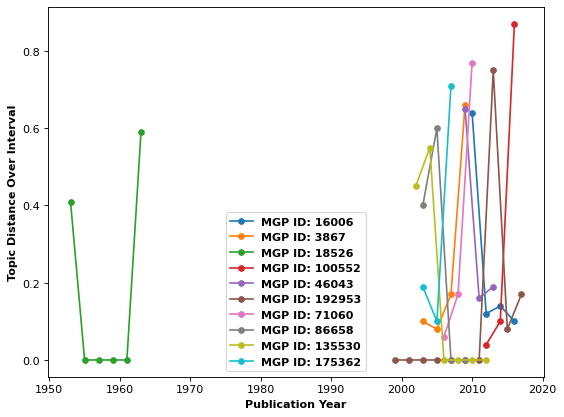

In [45]:
group_plot_metric(anti_persistent_res_kl[:10], interval_start_year, norm_distance_kl, group_head_id, name="not_persistent_kl",flag="researcher")

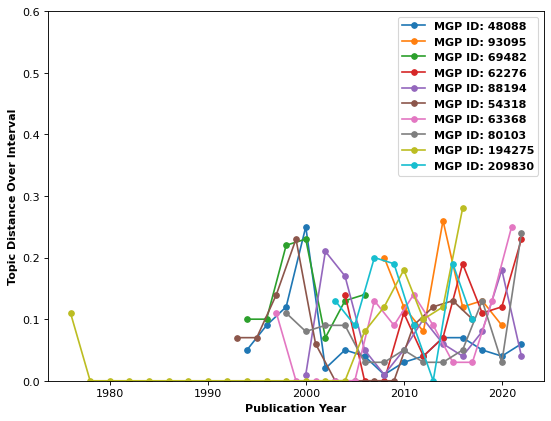

In [46]:
group_plot_metric(persistent_res_kl1[:10], interval_start_year, norm_distance_kl, group_head_id, name="persistent_kl_elbow",flag="researcher",ylim=(0,0.6))

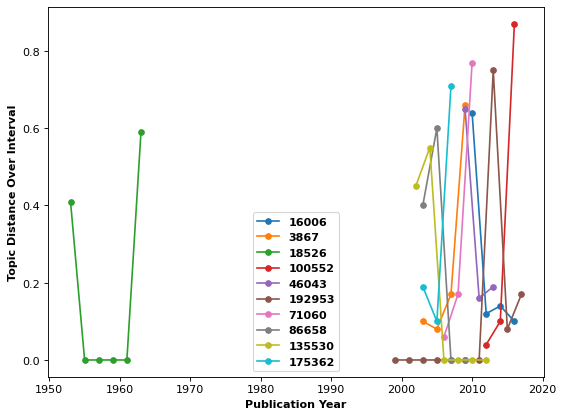

In [47]:
group_plot_metric(anti_persistent_res_kl1[:10], interval_start_year, norm_distance_kl, group_head_id, name="not_persistent_kl_elbow")#,flag="researcher")

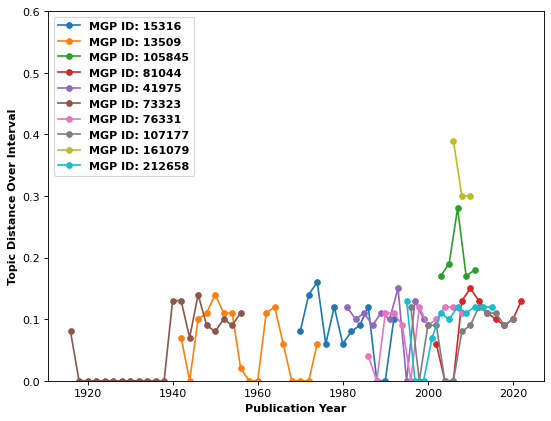

In [48]:
group_plot_metric(persistent_res_tau1[:10], interval_start_year, norm_distance_tau, group_head_id, name="persistent_jaccard_elbow",flag="researcher",ylim=(0,0.6))

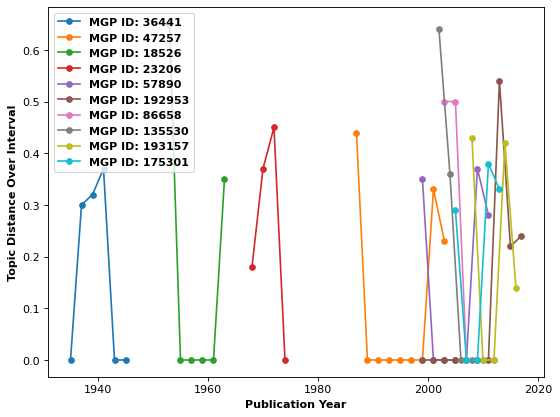

In [49]:
group_plot_metric(anti_persistent_res_tau1[:10], interval_start_year, norm_distance_tau, group_head_id, name="not_persistent_jaccard_elbow",flag="researcher")

In [60]:
#specific_plot_metric(95924, interval_start_year, norm_distance_tau, group_head_id)

In [61]:
#specific_plot_metric(265095, interval_start_year, norm_distance_kl, group_head_id)

In [62]:
#group_publication_titles[151149]

In [63]:
#topic_rank[10269]

In [ ]:
#norm_distance_tau[10269]

12158
9663
4904
7356
12979
4573


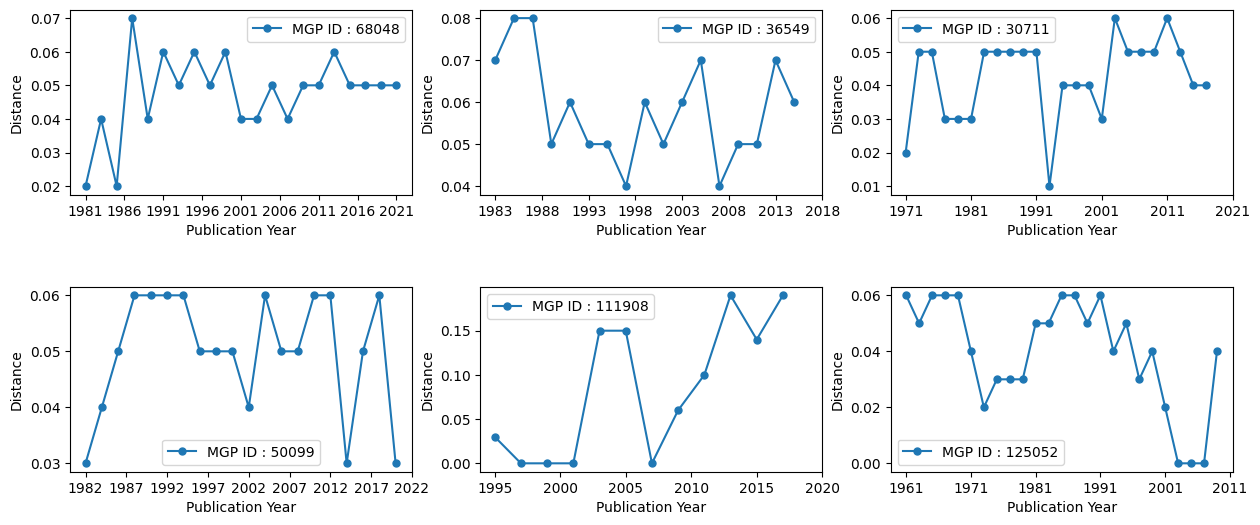

In [97]:
rounded_metric_dist = subplot_metric(interval_start_year, norm_distance_tau, group_head_id, 3)

12586
5417
8834
13876
4684
5423


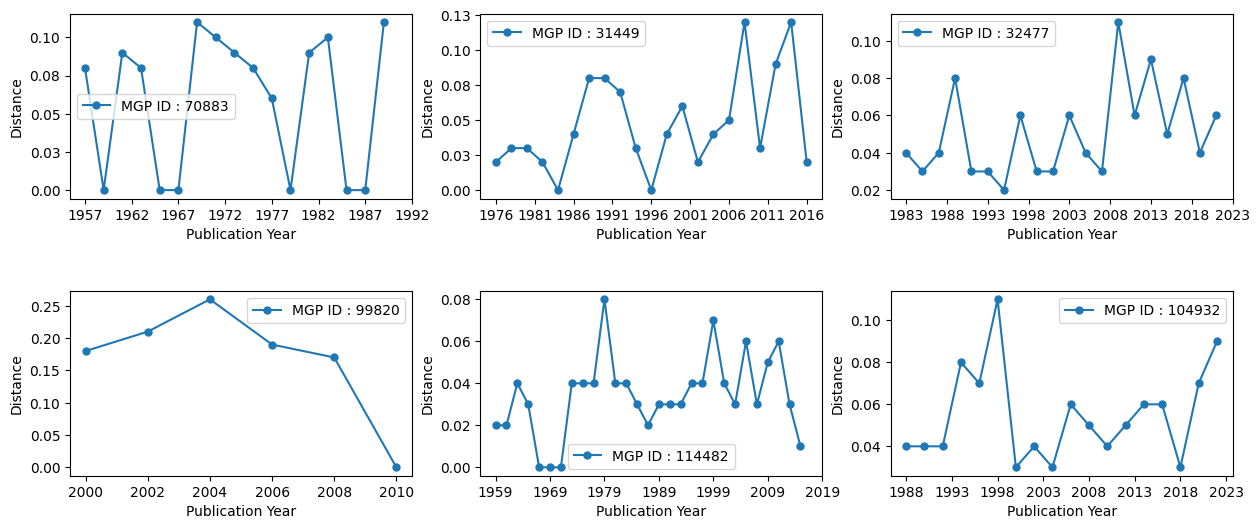

In [98]:
rounded_metric_dist = subplot_metric(interval_start_year, norm_distance_kl, group_head_id, 3)

In [ ]:
#norm_distance_kl

In [ ]:
# plot_metric(interval_start_year, norm_distance_tau, group_head_id, 5)

In [ ]:
# plot_metric(interval_start_year, norm_distance_kl, group_head_id, 5)

In [ ]:
#plot_devergance(sorted(metric_std_tau, reverse=True))

In [99]:
score_dict        = dict([(head, metric) for head, metric in zip(group_head_id, metric_std_kl)])

In [100]:
sorted_score_dict =  sorted(score_dict.items(), key= lambda x: x[1])

In [101]:
sorted_score_dict[-1]

(100552, 0.13575126)

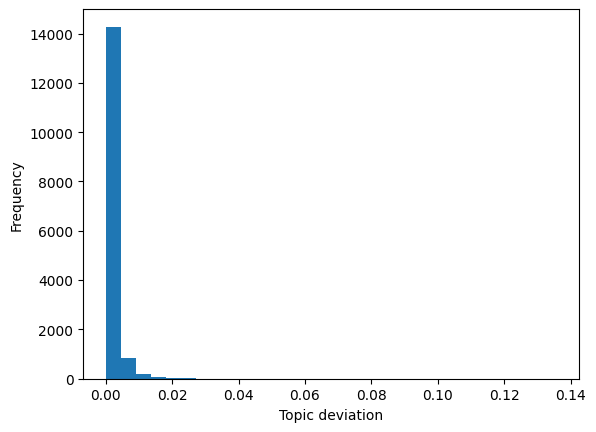

In [102]:
_= plt.hist(metric_std_kl, bins=30)
#plt.title("Deviation distribution")
plt.xlabel("Topic deviation")
plt.ylabel("Frequency")
plt.savefig("did_distribution_kl.pdf")
plt.show()

In [103]:
#const_add = 0.0000000001

In [104]:
#metric_std_tau = [m+const_add for m in metric_std_tau]

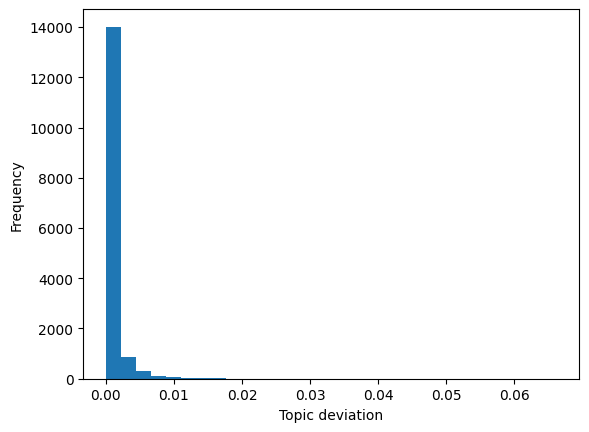

In [105]:
_= plt.hist(metric_std_tau, bins=30)
#plt.title("Deviation distribution")
plt.xlabel("Topic deviation")
plt.ylabel("Frequency")
plt.savefig("Did_distribution_MJC.pdf")
plt.show()

In [106]:
# plt.plot(sorted(metric_peaks_tau,reverse=True))
# plt.ylabel("No. of peaks")
# plt.xlabel("Researchers index")
# plt.show()

In [107]:
#metric_peaks_tau[0]

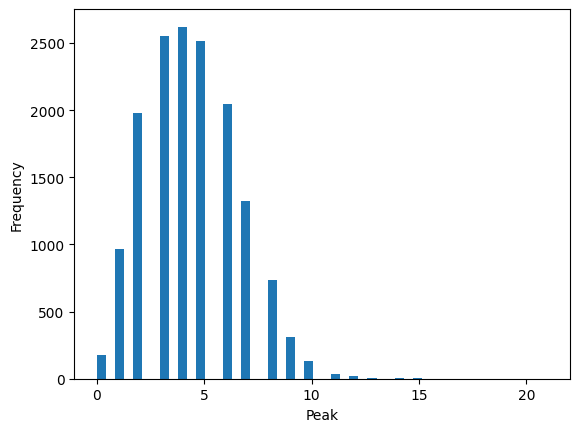

In [108]:
_= plt.hist(metric_peaks_tau, bins=50)
#plt.title("Peak Distribution")
plt.ylabel("Frequency")
plt.xlabel("Peak")
plt.savefig("peak_distribution.pdf")
plt.show()

In [109]:
# plt.plot(sorted(metric_hurst_exp_tau, reverse=True))
# plt.ylabel("hurst exponent value")
# plt.xlabel("Researchers index")
# plt.show()

In [110]:
# _= plt.hist(metric_hurst_exp_tau, bins=100)
# plt.title("Hurst exponent distribution")
# plt.show()

In [1]:
a =[1,2,3]

In [2]:
b=a

In [3]:
b.append(6)

In [4]:
print(a)

[1, 2, 3, 6]


In [6]:
print(b)

[1, 2, 3, 6]


In [8]:
id(a)

140672594848320

In [9]:
id(b)

140672594848320

In [10]:
a is b

True

In [11]:
c = []
d = []

In [12]:
c is d

False

In [13]:
c == d

True